<a href="https://colab.research.google.com/github/kiranraou/Python-Projects/blob/main/Test_Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sequence	Learning - End	Course	Test	

**DESCRIPTION**

Predict named entity from given data and showcase how entities like persons, locations, organizations, and 
other miscellaneous entity names of that do not belong to the previous three groups can be predicted from 
the tagged dataset. 

**Problem Statement:**

Using CoNLL 2003 data, predict tagged NER using CRF Algorithm. Also, tune the algorithm and explore the 
learnings that have been done by the CRF Model. 

**Dataset**

The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been 
put on a separate line, and there is an empty line after each sentence. The first item on each line is a word, 
the second a part-of-speech (POS) tag, the third a syntactic chunk tag, and the fourth the named entity tag. 
The chunk tags and the named entity tags have the format I-TYPE, which means that the word is inside a 
phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the 
second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a 
phrase. 

**Different Classes:**
1. persons, (PER) 
2. locations, (LOC) 
3. Organizations (ORG), 
4. names of miscellaneous entities that do not belong to the previous three groups (MISC)

**ConLL 2003 Data_Train Dataset Link**
 
https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/train.txt

**ConLL 2003 Data_Test Dataset Link**

https://raw.githubusercontent.com/davidsbatista/NER-datasets/master/CONLL2003/test.txt

**Mounting Google Drive.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import Libraries.**

In [4]:
import time
import pickle
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

%matplotlib inline
sns.set(font_scale=1.25)
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)

**Import and Examine Dataset.**

In [5]:
ner_data = '/content/drive/MyDrive/NIT Warangal _Industry Project/CONLL2003/train.txt'
df = pd.read_csv(ner_data, sep=' ', header=None)
df.columns = ['token', 'pos_tag', 'chunk_tag', 'ne_tag']
df.head()

,token,pos_tag,chunk_tag,ne_tag
0,-DOCSTART-,-X-,-X-,O
1,EU,NNP,B-NP,B-ORG
2,rejects,VBZ,B-VP,O
3,German,JJ,B-NP,B-MISC
4,call,NN,I-NP,O


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204567 entries, 0 to 204566
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   token      204564 non-null  object
 1   pos_tag    204567 non-null  object
 2   chunk_tag  204567 non-null  object
 3   ne_tag     202389 non-null  object
dtypes: object(4)
memory usage: 6.2+ MB


In [7]:
null_columns = df.columns[df.isnull().any()]
print(df[null_columns].isnull().sum())

df[df.isnull().any(axis=1)][null_columns].head()

token        3
ne_tag    2178
dtype: int64


,token,ne_tag
75,,NaN
93,,NaN
260,,NaN
264,,NaN
366,,NaN


In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True) # Reset the index so that it reflects the length of the dataframe and its columns. 
df.info() # Confirm that the missing values have been dropped.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202386 entries, 0 to 202385
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   token      202386 non-null  object
 1   pos_tag    202386 non-null  object
 2   chunk_tag  202386 non-null  object
 3   ne_tag     202386 non-null  object
dtypes: object(4)
memory usage: 6.2+ MB


In [9]:
df.pos_tag.value_counts()

NNP       34390
NN        23898
CD        19704
IN        19064
DT        13453
JJ        11831
NNS        9903
VBD        8293
.          7389
,          7291
VB         4252
VBN        4105
RB         3975
CC         3653
TO         3469
PRP        3163
)          2866
(          2866
VBG        2585
VBZ        2426
:          2386
POS        1553
PRP$       1520
VBP        1436
MD         1199
-X-         946
NNPS        684
WP          528
RP          528
WDT         506
SYM         439
$           427
WRB         384
JJR         382
JJS         254
FW          166
RBR         163
EX          136
''           35
RBS          35
PDT          33
UH           30
WP$          23
LS           13
NN|SYM        4
Name: pos_tag, dtype: int64

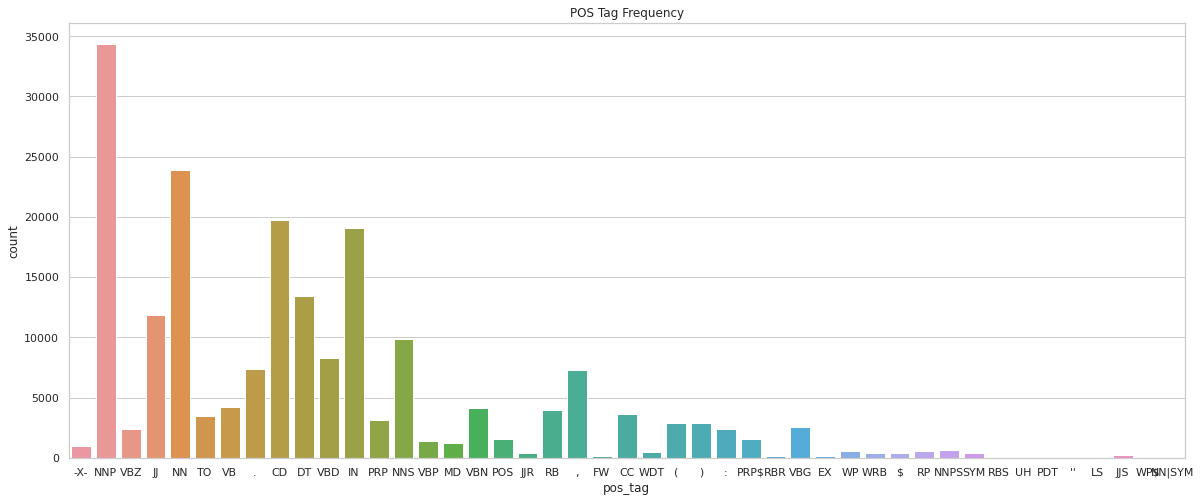

In [10]:
fig = plt.figure(figsize=(20,8))
plt.title('POS Tag Frequency')
sns.countplot(data=df, x='pos_tag');

In [11]:
df.chunk_tag.value_counts()

I-NP       66645
B-NP       57384
O          25468
B-PP       18843
B-VP       18047
I-VP        8818
B-ADVP      2637
B-SBAR      1269
B-ADJP      1165
-X-          946
B-PRT        527
I-ADJP       211
I-ADVP       138
I-PP         103
B-INTJ        59
I-CONJP       39
B-LST         32
B-CONJP       31
I-SBAR        19
I-LST          4
I-INTJ         1
Name: chunk_tag, dtype: int64

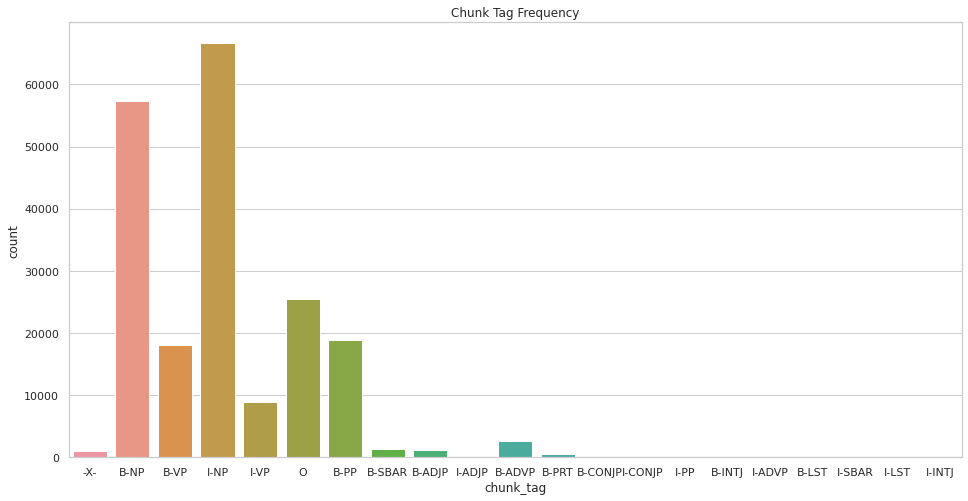

In [12]:
fig = plt.figure(figsize=(16,8))
plt.title('Chunk Tag Frequency')
sns.countplot(data=df, x='chunk_tag');

In [13]:
df.ne_tag.value_counts()

O         168343
B-LOC       7140
B-PER       6600
B-ORG       6321
I-PER       4528
I-ORG       3704
B-MISC      3438
I-LOC       1157
I-MISC      1155
Name: ne_tag, dtype: int64

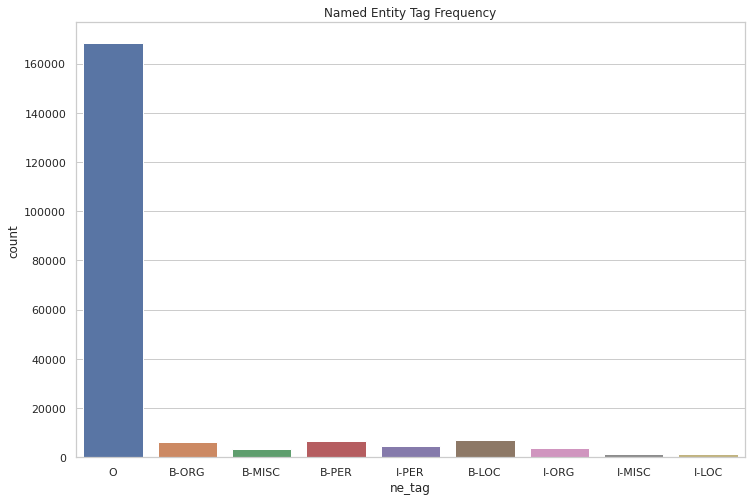

In [14]:
fig = plt.figure(figsize=(12,8))
plt.title('Named Entity Tag Frequency')
sns.countplot(data=df, x='ne_tag');

In [15]:
#df[df.ne_tag=='B-ORG'].sample(20) # First word in organisation name. Some tokens are abbreviations in all caps (e.g., 'EU').
#df[df.ne_tag=='I-ORG'].sample(20) # Second word in organisation name.
#df[df.ne_tag=='B-MISC'].sample(20) # Not sure how this differs from B-ORG. Many are adjectives.
#df[df.ne_tag=='I-MISC'].sample(20) # Second part of B-MISC.
df[df.ne_tag=='B-PER'].sample(20) # First names of people.
#df[df.ne_tag=='I-PER'].sample(20) # Surnames of people. Mostly capitalised but not always (e.g., 'van').
#df[df.ne_tag=='B-LOC'].sample(20) # Country and city names.
#df[df.ne_tag=='I-LOC'].sample(20) # Second part of country and city names.

,token,pos_tag,chunk_tag,ne_tag
192044,Fowler,NNP,B-NP,B-PER
116491,Gilbert,NNP,I-NP,B-PER
192965,Baker,NNP,B-NP,B-PER
113118,Karin,NNP,B-NP,B-PER
150298,Jacqueline,NNP,I-NP,B-PER
9343,Cecil,NNP,B-NP,B-PER
113361,Renzo,NNP,B-NP,B-PER
91599,Alex,NNP,B-NP,B-PER
148741,Desmond,NNP,I-NP,B-PER
111913,Lupu,NNP,B-NP,B-PER


**Feature Engineering and Prepare Training and Validation Sets.**

In [16]:
def features(token, index, pos_tag, ne_tag):
    first_letter = token[index][0]
    features = {'token': token[index],
                'pos': pos_tag[index],
#                'chunk': chunk_tag[index],
                'prev_token': '' if index == 0 else token[index-1],
                'prev_pos': '' if index == 0 else pos_tag[index-1],
                'prev_ne': '' if index == 0 else ne_tag[index-1],
                'next_token': '' if index == len(df.token)-1 else token[index+1],
                'next_pos': '' if index == len(df.token)-1 else pos_tag[index+1],
                'prev_prev_token': '' if index == 0 or index == 1 else token[index-2],
                'prev_prev_pos': '' if index == 0 or index == 1 else pos_tag[index-2],
                'next_next_token': '' if index == len(df.token)-1 or index == len(df.token)-2 else token[index+2],
                'next_next_pos': '' if index == len(df.token)-1 or index == len(df.token)-2 else pos_tag[index+2],
                'is_capitalized': first_letter.upper() in string.ascii_uppercase and first_letter.upper() == first_letter,
                'is_numeric': token[index].isdigit(),                
                'is_all_caps': token[index].upper() == token[index],
                'caps_inside': token[index][1:].lower() != token[index][1:]
                }
    return features
    
X = []

for index in range(len(df.token)):
    X.append(features(df.token, index, df.pos_tag, df.ne_tag))

In [17]:

X[:5]

[{'caps_inside': True,
  'is_all_caps': True,
  'is_capitalized': False,
  'is_numeric': False,
  'next_next_pos': 'VBZ',
  'next_next_token': 'rejects',
  'next_pos': 'NNP',
  'next_token': 'EU',
  'pos': '-X-',
  'prev_ne': '',
  'prev_pos': '',
  'prev_prev_pos': '',
  'prev_prev_token': '',
  'prev_token': '',
  'token': '-DOCSTART-'},
 {'caps_inside': True,
  'is_all_caps': True,
  'is_capitalized': True,
  'is_numeric': False,
  'next_next_pos': 'JJ',
  'next_next_token': 'German',
  'next_pos': 'VBZ',
  'next_token': 'rejects',
  'pos': 'NNP',
  'prev_ne': 'O',
  'prev_pos': '-X-',
  'prev_prev_pos': '',
  'prev_prev_token': '',
  'prev_token': '-DOCSTART-',
  'token': 'EU'},
 {'caps_inside': False,
  'is_all_caps': False,
  'is_capitalized': False,
  'is_numeric': False,
  'next_next_pos': 'NN',
  'next_next_token': 'call',
  'next_pos': 'JJ',
  'next_token': 'German',
  'pos': 'VBZ',
  'prev_ne': 'B-ORG',
  'prev_pos': 'NNP',
  'prev_prev_pos': '-X-',
  'prev_prev_token': '-DO

In [18]:
y = df['ne_tag']

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.1, random_state=0)

print("Size of training set (POS tags):", len(X_train)) 
print("Size of test set (POS tags):", len(X_test)) 
print("Size of training set (chunk tags):", len(y_train)) 
print("Size of test set (chunk tags):", len(y_test))

Size of training set (POS tags): 182147
Size of test set (POS tags): 20239
Size of training set (chunk tags): 182147
Size of test set (chunk tags): 20239


# **Classifier Training.**

**F1 score.**

In [19]:
# token, pos: 0.8932555327159474
# token, chunk: 0.8494862890783083 (took a LOT longer)
# token, pos, chunk: 0.8957114704338746 (chunk doesn't help)
# token, pos, previous token/pos: 0.8995017958096173
# token, pos, previous token/pos, next token/pos: 0.9055109354730966
# token, pos, previous token/pos, next token/pos, is_capitalised: 0.9115229634875965
# token, pos, previous token/pos, previous previous token/pos, next token/pos, next next token/pos, is_capitalised: 0.9128023148431639
# '', is_numeric: 0.9127205040729689
# '', is_all_caps: 0.9132049059426229
# '', caps_inside: 0.9142095785522023
# ', prev_ne: 0.9387959473000405

start_time = time.time()

clf_dt = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', DecisionTreeClassifier(random_state=0, criterion='entropy'))])
 
clf_dt.fit(X_train[:10000], y_train[:10000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_dt = clf_dt.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_dt, average='weighted'))

Total time: 8.923581600189209
Mean F1 score (weighted): 0.933595041061099


In [20]:
start_time = time.time()

clf_nb = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                   ('classifier', MultinomialNB(alpha=0.01))])
 
clf_nb.fit(X_train[:30000], y_train[:30000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_nb = clf_nb.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_nb, average='weighted'))

Total time: 10.791502952575684
Mean F1 score (weighted): 0.9426518311998823


In [21]:
start_time = time.time()

clf_svc = Pipeline([('vectorizer', DictVectorizer(sparse=False)),
                    ('classifier', LinearSVC(random_state=0, class_weight='balanced', max_iter=10000))])
 
clf_svc.fit(X_train[:30000], y_train[:30000])

end_time = time.time()
print("Total time:", end_time-start_time)

predicted_svc = clf_svc.predict(X_test)
print("Mean F1 score (weighted):", metrics.f1_score(y_test, predicted_svc, average='weighted'))

Total time: 9.731555700302124
Mean F1 score (weighted): 0.9671038352638052


In [22]:
print(metrics.classification_report(y_test, predicted_svc))

              precision    recall  f1-score   support

       B-LOC       0.83      0.86      0.85       706
      B-MISC       0.78      0.75      0.77       359
       B-ORG       0.74      0.72      0.73       604
       B-PER       0.83      0.87      0.85       665
       I-LOC       0.88      0.97      0.92       119
      I-MISC       0.83      0.81      0.82       116
       I-ORG       0.94      0.95      0.94       386
       I-PER       0.99      1.00      0.99       465
           O       0.99      0.99      0.99     16819

    accuracy                           0.97     20239
   macro avg       0.87      0.88      0.87     20239
weighted avg       0.97      0.97      0.97     20239



**Saving Model with pickle.**

In [23]:
save_classifier = open('ne_clf_svc.pickle', 'wb') 
pickle.dump(clf_svc, save_classifier)
save_classifier.close()